In [1]:
import os
import random
import time
import datetime
import platform
import copy
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
# import torch.nn as nn 
# import torch.optim as optim 
from torch.optim import lr_scheduler 

import torchvision
from torchvision import transforms, models, datasets, utils

import splitfolders

In [2]:
torch.cuda.is_available()

# Verifica se a GPU está disponível
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print('\nDevice: {0}'.format(device))

# print(torch.cuda.get_device_name(0))

# !nvidia-smi

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
def initialize_model(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights='DEFAULT')
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(weights='DEFAULT')
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(weights='DEFAULT')
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(weights='DEFAULT')
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(weights='DEFAULT')
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(weights='DEFAULT')
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [4]:
# base_dir = 'data\RoCole\sorted_binary'

# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(base_dir, output="splited", seed=42, ratio=(.8, .2)) # default values
# print("Splits Ok!")

In [5]:
# Define o caminho base do diretório de imagens divididas 
base_dir = 'data\splited\\'

# Número de classes
num_classes = 2

# Nomes das classes
class_names = ['healthy', 'unhealthy']

# Tamanho do lote (mini-batch)
batch_size = 32

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 5 # Usar durante o desenvolvimento
### epochs = 50 

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

model_ft, input_size = initialize_model(model_name, num_classes)

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


Initializing Datasets and Dataloaders...


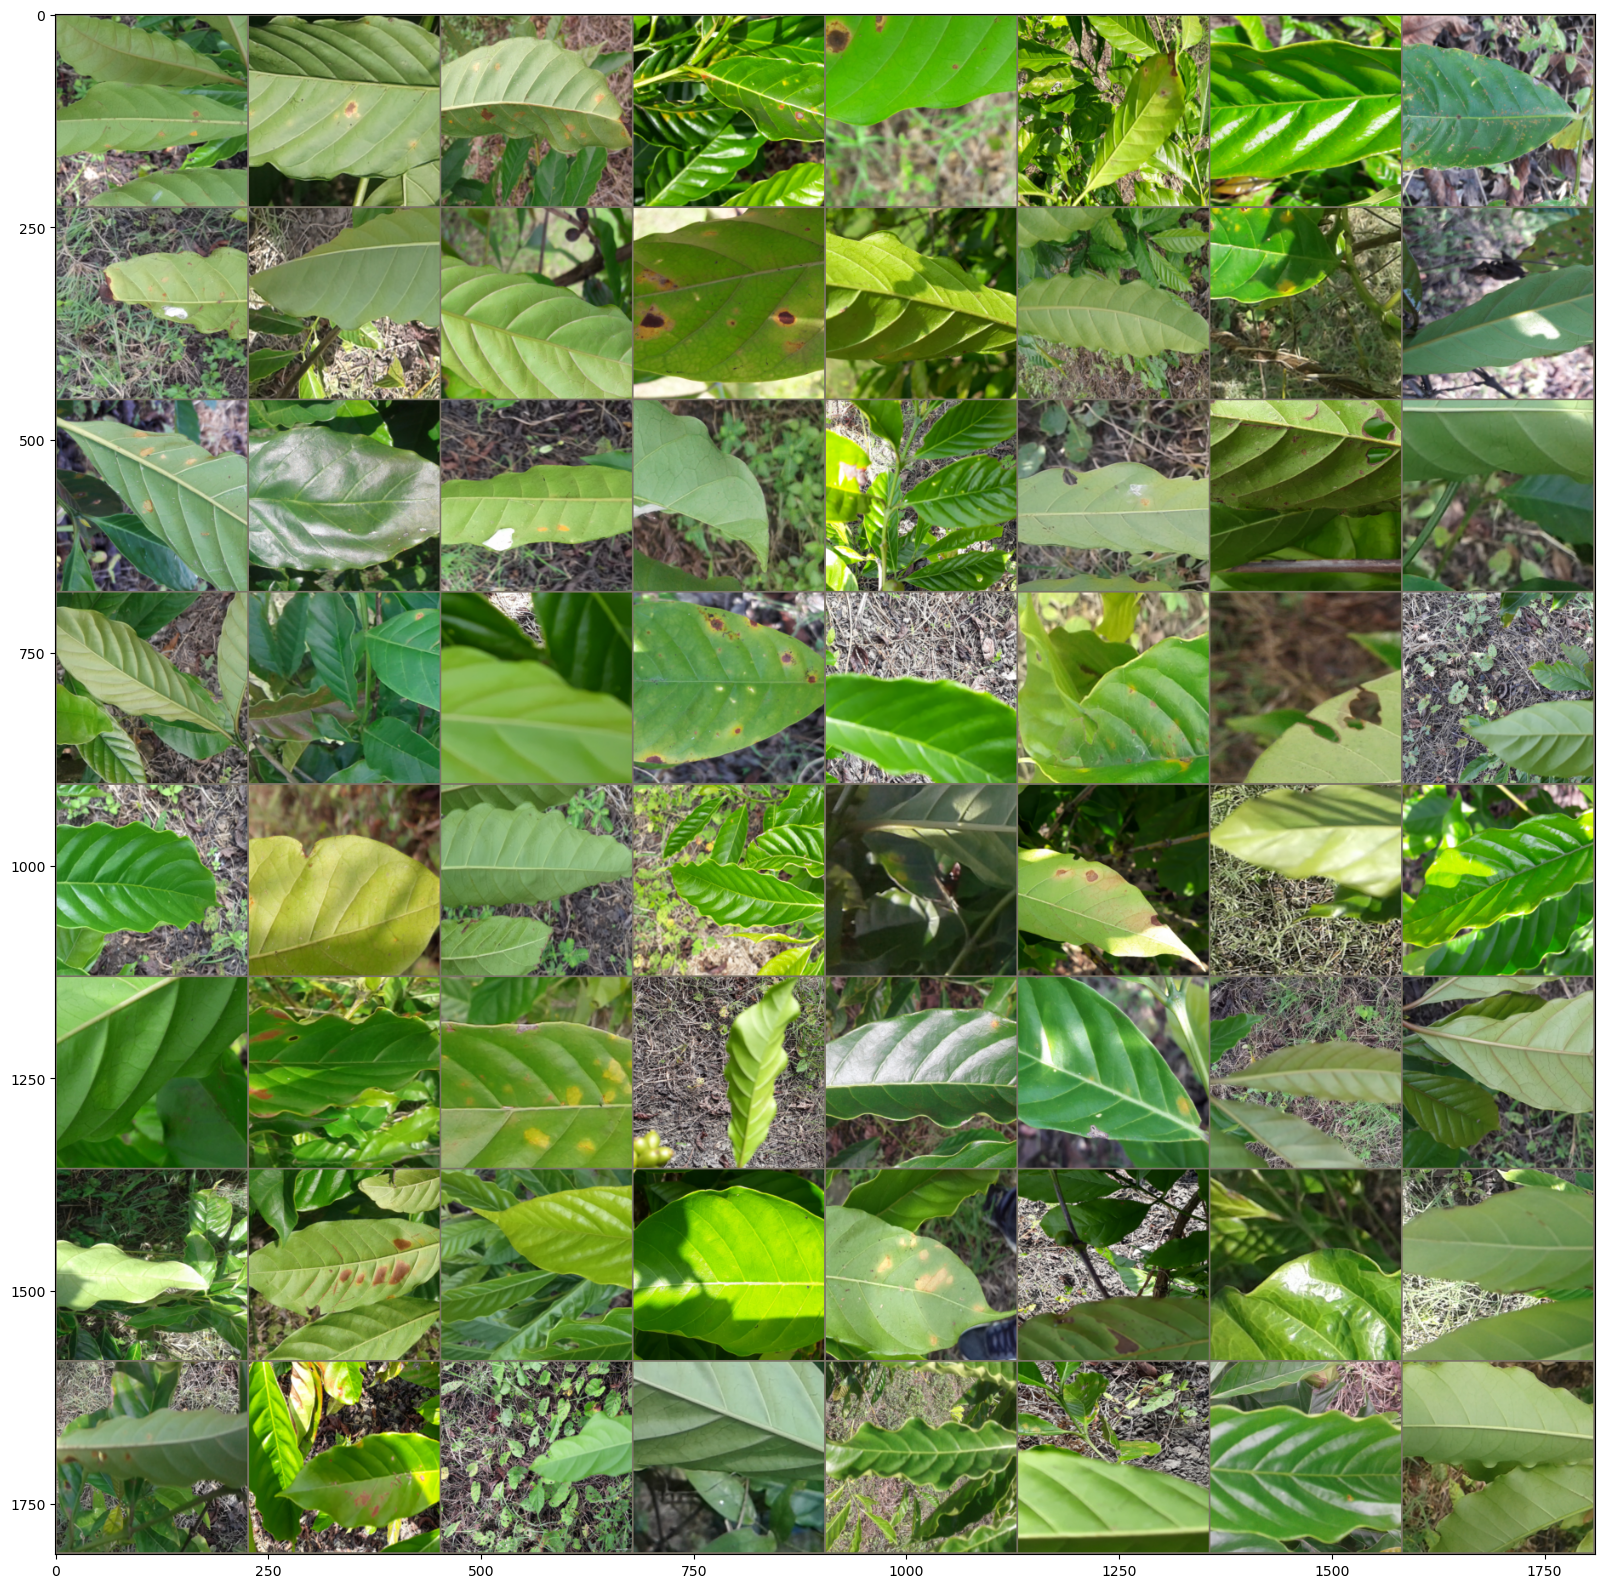

In [7]:
def show_transformed_image(image):
    # Unnormalize all channels 
    ### for t, m, s in zip(np_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): # (ImageNet weights)       
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=image_datasets['train'], shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label = next(items)

show_transformed_image(utils.make_grid(image))

In [8]:
# Número de imagens em cada dataset
train_size = 0
val_size = 0

for name, data in image_datasets.items():
    if name == 'train':
        train_size = len(data)
    else:
        val_size = len(data)

    print(f'Data set: {name}. Size: {len(data)}')


Data set: train. Size: 1247
Data set: val. Size: 313


In [9]:
# Pretrainned
model_ft = model_ft.to(device)

# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model_ft.parameters(), lr=lr, momentum=mm)
  
# Imprime o modelo
print(str(model_ft))


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
def evaluate_model(model, dataloader, device):
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true += labels.tolist()
            y_pred += predicted.tolist()

    return y_true, y_pred

In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs, model_name, date_now, save_dir):
    """
    Plota gráfico de loss e accuracy por epoch para conjunto de treinamento e validação
    
    Args:
        train_losses (list): Lista com os valores de loss do conjunto de treinamento por epoch
        val_losses (list): Lista com os valores de loss do conjunto de validação por epoch
        train_accs (list): Lista com os valores de accuracy do conjunto de treinamento por epoch
        val_accs (list): Lista com os valores de accuracy do conjunto de validação por epoch
    
    Returns:
        None
    """
    # Define o número de epochs
    epochs = len(train_losses)
    
    # Define o eixo x do gráfico como o número de epochs
    x = range(1, epochs + 1)
    
    # Plota os gráficos de loss e accuracy para conjunto de treinamento e validação
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
    plt.plot(x, val_losses, c='green' ,ls='--', label='Val. loss', fillstyle='none')
    plt.title('Loss por epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, [acc.cpu() for acc in train_accs], c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
    plt.plot(x, [acc.cpu() for acc in val_accs], c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
    plt.title('Accuracy por epoch')
    plt.legend()
    
    plt.savefig(f'{save_dir}/{model_name}_loss_acc_{date_now}.pdf')
    plt.show()

In [13]:
def generate_classification_report(model, dataloader,class_name, device='cpu'):
    # Define o modelo para o dispositivo correto (CPU ou GPU)
    model = model.to(device)
    model.eval()
    
    # Inicializa as variáveis de predições e rótulos verdadeiros
    all_preds = torch.tensor([], dtype=torch.long, device=device)
    all_labels = torch.tensor([], dtype=torch.long, device=device)

    # Realiza a predição para cada lote de dados no dataloader
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Adiciona as predições e rótulos verdadeiros às variáveis criadas anteriormente
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Gera o classification report com base nas predições e rótulos verdadeiros
    report = metrics.classification_report(all_labels.cpu().numpy(), all_preds.cpu().numpy(),target_names=class_names,
                                           digits=4, zero_division=0)
    
    return report

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu', model_name='model'):
    
    # Tempo total do treinamento (treinamento e validação)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    # Cria a pasta com o nome do modelo
    output_dir = 'outputs\\' + model_name
    os.makedirs(output_dir, exist_ok=True)

    date_now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Cria a pasta para separar os testes
    result_dir = output_dir + '\\' + model_name +'_' + date_now
    print(result_dir)
    os.makedirs(result_dir, exist_ok=True)

    # Abre o arquivo para salvar o resultado
    f = open(f'{result_dir}/{model_name}_{date_now}.txt', 'w')
    
    for epoch in range(num_epochs):
        f.write(f'Epoch {epoch}/{num_epochs - 1}\n')
        f.write('-' * 10 + '\n')

        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            # Inicia contagem de tempo da época
            time_epoch_start = time.time()

            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Perda (loss) nesta época
            running_loss = 0.0
            # Amostras classificadas corretamente nesta época
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if model_name == 'inception' and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Atualiza a perda da época
                running_loss += loss.item() * inputs.size(0)
                # Atualiza o número de amostras classificadas corretamente na época.
                running_corrects += torch.sum(preds == labels.data)
            # Perda desta época
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # Acurácia desta época
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Tempo total desta época
            time_epoch = time.time() - time_epoch_start

            f.write(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds) \n')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({time_epoch:.4f} seconds)')

            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_epoch = time.time() - since

        f.write(f'Time: {time_epoch:.0f}s\n')
        f.write('\n')

        print(f'Time: {time_epoch:.0f}s')
        print('\n')

    time_elapsed = time.time() - since
    f.write(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s\n')
    f.write(f'Number of epochs: {num_epochs}\n')
    f.write(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}\n')

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f} Best val acc: {best_acc:.4f}')

    # Save the confusion matrix
    y_true, y_pred = evaluate_model(model, dataloaders['val'], device=device)
    # Confusion matrix
    conf_mat_val = metrics.confusion_matrix(y_true, y_pred)
    f.write(f'\nConfusion Matrix:\n{conf_mat_val}\n')

    print(f'Confusion Matrix:\n{conf_mat_val}')

    # Classification report 
    class_rep_val = generate_classification_report(model_ft, dataloaders_dict['val'],model_name, device)    
    f.write(f'\nClassification report:\n{class_rep_val}\n')


    f.close()

    # Save the plot
    plt.figure()
    plot_confusion_matrix(conf_mat_val, classes=class_names)
    plt.savefig(f'{result_dir}/{model_name}_cf_mat_{date_now}.pdf')

    #Plota gráfico de loss e accuracy por epoch
    plot_loss_accuracy(train_loss_list, val_loss_list, train_acc_list, val_acc_list, model_name, date_now, result_dir)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

outputs\alexnet\alexnet_2023-04-23_12-07-29
Epoch 0/4
----------
train Loss: 0.2985 Acc: 0.8709 (16.0212 seconds)
val Loss: 0.2630 Acc: 0.8882 (5.7162 seconds)
Time: 22s


Epoch 1/4
----------
train Loss: 0.2947 Acc: 0.8741 (15.5781 seconds)
val Loss: 0.2483 Acc: 0.8914 (5.7392 seconds)
Time: 43s


Epoch 2/4
----------
train Loss: 0.2827 Acc: 0.8813 (15.5165 seconds)
val Loss: 0.2283 Acc: 0.9105 (5.7042 seconds)
Time: 64s


Epoch 3/4
----------
train Loss: 0.2696 Acc: 0.8917 (16.4050 seconds)
val Loss: 0.2104 Acc: 0.9169 (5.8005 seconds)
Time: 86s


Epoch 4/4
----------
train Loss: 0.2672 Acc: 0.8901 (15.7503 seconds)
val Loss: 0.1960 Acc: 0.9201 (5.9815 seconds)
Time: 108s


Training complete in 1m 48s
Best val loss: 0.1960 Best val acc: 0.9201
Confusion Matrix:
[[145  14]
 [ 11 143]]


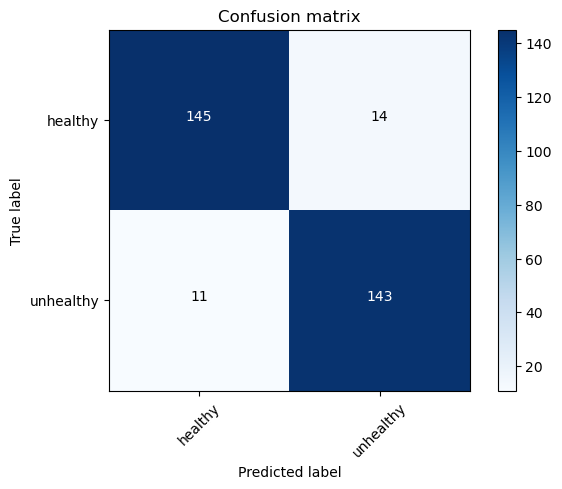

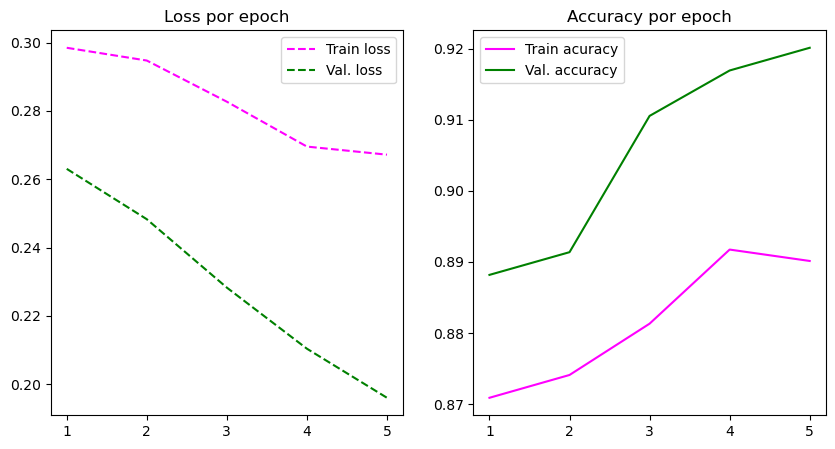

In [22]:
model_ft = train_model(model_ft, dataloaders_dict, criterion, optimizer, epochs, device, model_name)

In [16]:
# Lista com as classes reais e classes preditas
true_val_list = []
pred_val_list = []
# Lista com as probabilidades
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, labelList) in enumerate(dataloaders_dict['val']):

    # if DEVICE.type == 'cuda':
    img_list = img_list.to(device)
    labelList = labelList.to(device)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False) 

    # -----> FORWARD
    # Saída do modelo
    outputs = model_ft(img_list)

    # Predição
    ### _, preds = torch.max(output, 1)
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades 
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_val_batch = np.asarray(outputs_prob.cpu())

    # Classes reais true) e classes preditas (pred) para este lote.
    # if DEVICE.type == 'cuda':
    true_val_batch = np.asarray(labelList.cpu())
    pred_val_batch = np.asarray(preds.cpu())
        
    # Itera ao longo do lote
    for i in range(0, len(pred_val_batch)):
        true_val_list.append(true_val_batch[i])
        pred_val_list.append(pred_val_batch[i])

        prob_val_list.append(prob_val_batch[i])

In [17]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list, 
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[155   4]
 [ 27 127]]

Class. report (validation)
              precision    recall  f1-score   support

     healthy     0.8516    0.9748    0.9091       159
   unhealthy     0.9695    0.8247    0.8912       154

    accuracy                         0.9010       313
   macro avg     0.9106    0.8998    0.9002       313
weighted avg     0.9096    0.9010    0.9003       313



Validation Acc.: 0.9010
